# Principal Component Analysis - PCA 

Just like clustering is a partitioning of the dataset based on proximity, you could think of PCA as a partintioning of the variation in the data. Is a great tool to help you discover important relationships in the dataand can also be used to create more informative features. 

**Technical note:** PCA is typically applied to standardized data. With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance". All data in this course will be standardized before applying PCA.

- [Video Explanation](https://www.youtube.com/watch?v=FgakZw6K1QQ) about PCA

The use of PCA lets you describe the data with its axes of variation, instead of describing with the original features. The new features are actually just linear combinations (weighted sums) of the original features.
These new features are called the **principal components** of the data. The weights are called **loadings**. There will be as many principal components as there are features in the original dataset. The component's loadings tell us what variation it expresses through signs and magnitudes:

![](images/2022-06-14-17-21-35.png)

![](images/2022-06-14-17-21-54.png)
![](images/2022-06-14-17-22-15.png)

This tables is telling us that in the `Size` component, `Height` and `Diameter` vary in the same direction, but in the `Shape` component they vary in opposite directions (opposite signs). In each component, the **loadings** are all the same magnitude and so the features contribute equally in both. 

PCA tells us the **amount of variation** in each component. We can see from the figures, that there is more variation in the data along the `Size` component than along the `Shape` component. PCA makes this precise through each component's **percent of explained variance**. 

![](images/2022-06-14-17-26-14.png)

The `Size` component captures the **majority of the variation** between `Height` and `Diameter`. It's important to remember, however, that the amount of variance in a component doesn't necessarily correspond to how good it is as a predictor: it depends on what you're trying to predict.

### Apply it in Feature Engineering

There are two ways one can use it in feature engineering:
1. As a **descriptive technique**:

    Since the components tell us about the variation, you could compute the **MI scores** for the components and see what kind of variation is most predictive of your target. That can give you a hint to what kind of features to create, for instance: `a product of Height and Diameter if Size is important`; You could even try to cluster on one or more of the high-scoring components.

2. Use the **components** as **features**:

    Since they expose variations of the data -> they can often be more informative than the original features. Some use cases:
    - **Dimensional Reduction** - When features are highly redundant (multicollinear, specifically), PCA will partition out that redundancy into one or more near-zero variance components, which can then be drop since they will contain little or no information;
    - **Anomaly Detection** - Unusual variation, not apparent from the original features -> will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task;
    - **Noise reduction** - A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio;
    - **Decorrelation** - Some algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

**Best Pratices**
- Only words with numeric features, like continuous quantities or counts;
- Is sensitive to scale -> It is good prative to standardize your data before applying PCA, unless you know you have good reason not to;
- Consider removing or constraining outliers, since they can have an undue influence on the results

#### Example: Discover features on Automobile Data set

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("data/autos.csv")

In [2]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [3]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


- After fitting, the PCA instance contains the loadings in its components_ attribute. We will wrap the loadings up in a dataframe

In [4]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured.

PC1 shows:
- A contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage - we might call this the **"Luxury/Economy" axis**

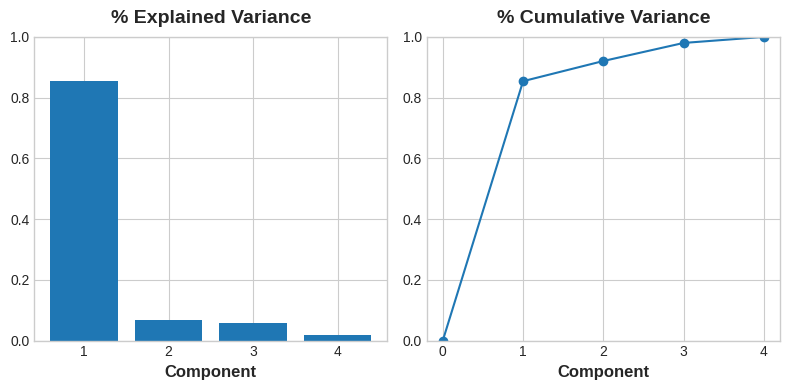

In [5]:
# Look at explained variance
plot_variance(pca);

The above figure shows that our four chosen features mostly vary along the **Luxury/Economy axis**

Lets take a look at **MI scores** of the components:

In [6]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.012428
PC2    0.378939
PC3    0.306298
PC4    0.204071
Name: MI Scores, dtype: float64

Not surprinsingly - **PC1** - is highly informative, though the remaining components, despite their small variance, still have a significant relationship with **price**. Examining those can be worthwhile to find other types of relationships

The **PC3** shows a contrast between `horsepower` and `curb_weight` -- sports cars vs. wagons it seems.

In [7]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


To express this contrast, let's create a new ratio feature:

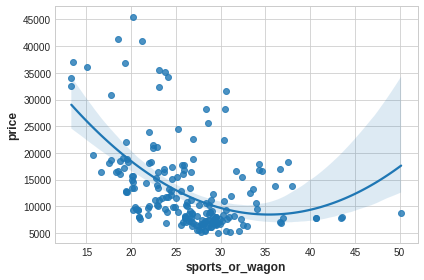

In [8]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);

This type of feature might help in the prediction of price, for this especific examples

### Lab Code

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBRegressor

# # Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc(
#     "axes",
#     labelweight="bold",
#     labelsize="large",
#     titleweight="bold",
#     titlesize=14,
#     titlepad=10,
# )


# def apply_pca(X, standardize=True):
#     # Standardize
#     if standardize:
#         X = (X - X.mean(axis=0)) / X.std(axis=0)
#     # Create principal components
#     pca = PCA()
#     X_pca = pca.fit_transform(X)
#     # Convert to dataframe
#     component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
#     X_pca = pd.DataFrame(X_pca, columns=component_names)
#     # Create loadings
#     loadings = pd.DataFrame(
#         pca.components_.T,  # transpose the matrix of loadings
#         columns=component_names,  # so the columns are the principal components
#         index=X.columns,  # and the rows are the original features
#     )
#     return pca, X_pca, loadings


# def plot_variance(pca, width=8, dpi=100):
#     # Create figure
#     fig, axs = plt.subplots(1, 2)
#     n = pca.n_components_
#     grid = np.arange(1, n + 1)
#     # Explained variance
#     evr = pca.explained_variance_ratio_
#     axs[0].bar(grid, evr)
#     axs[0].set(
#         xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
#     )
#     # Cumulative Variance
#     cv = np.cumsum(evr)
#     axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
#     axs[1].set(
#         xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
#     )
#     # Set up figure
#     fig.set(figwidth=8, dpi=100)
#     return axs


# def make_mi_scores(X, y):
#     X = X.copy()
#     for colname in X.select_dtypes(["object", "category"]):
#         X[colname], _ = X[colname].factorize()
#     # All discrete features should now have integer dtypes
#     discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores


# def score_dataset(X, y, model=XGBRegressor()):
#     # Label encoding for categoricals
#     for colname in X.select_dtypes(["category", "object"]):
#         X[colname], _ = X[colname].factorize()
#     # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
#     score = cross_val_score(
#         model, X, y, cv=5, scoring="neg_mean_squared_log_error",
#     )
#     score = -1 * score.mean()
#     score = np.sqrt(score)
#     return score